#  Setup

In [133]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pybaseball.cache.enable()
data = statcast('2022-04-07', '2022-10-05')

print(data.shape)
data.head(10)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.8/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 182/182 [13:44<00:00,  4.53s/it]


(708540, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3171,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3387,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3467,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3590,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3846,FC,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031
3886,FF,2022-10-05,97.5,-0.56,6.68,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,194,0.0,0.023
4028,CH,2022-10-05,84.9,-0.58,6.65,"Baker, Bryan",665489,641329,strikeout,called_strike,...,5,4,5,4,5,Standard,Standard,207,0.071,-0.158
4181,FF,2022-10-05,98.2,-0.59,6.72,"Baker, Bryan",665489,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,190,0.0,0.017
4387,CH,2022-10-05,83.8,-0.41,6.57,"Baker, Bryan",665489,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,211,0.0,-0.046
4557,FF,2022-10-05,96.7,-0.41,6.75,"Baker, Bryan",665489,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.034


In [87]:
data = pd.read_csv('data2022.csv')
data.shape

(42130, 93)

# Data Cleaning

## Determining Training Data Columns

In [88]:
for i in zip(data.columns, data.dtypes):
  print(i)

('Unnamed: 0', dtype('int64'))
('pitch_type', dtype('O'))
('game_date', dtype('O'))
('release_speed', dtype('float64'))
('release_pos_x', dtype('float64'))
('release_pos_z', dtype('float64'))
('player_name', dtype('O'))
('batter', dtype('int64'))
('pitcher', dtype('int64'))
('events', dtype('O'))
('description', dtype('O'))
('spin_dir', dtype('float64'))
('spin_rate_deprecated', dtype('float64'))
('break_angle_deprecated', dtype('float64'))
('break_length_deprecated', dtype('float64'))
('zone', dtype('int64'))
('des', dtype('O'))
('game_type', dtype('O'))
('stand', dtype('O'))
('p_throws', dtype('O'))
('home_team', dtype('O'))
('away_team', dtype('O'))
('type', dtype('O'))
('hit_location', dtype('float64'))
('bb_type', dtype('O'))
('balls', dtype('int64'))
('strikes', dtype('int64'))
('game_year', dtype('int64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))
('on_3b', dtype('float64'))
('on_2b', dtype('float64'))
('o

https://baseballsavant.mlb.com/csv-docs 

Which columns should we keep based on the documentation? Any metrics derived from the movement of the pitch alone, with no regard for the pitcher who threw it except for the handedness of the pitcher.
  - Motivation: different pitch mixes for different hands of pitchers (e.g. more right-handed changeups than left-handed)

In [89]:
data = data[['pitcher', 'player_name', 'pitch_type', "p_throws",'pitch_name', 'release_spin_rate', 'release_speed','effective_speed', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [90]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', dtype('int64'))
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', dtype('float64'))
('release_speed', dtype('float64'))
('effective_speed', dtype('float64'))
('spin_axis', dtype('float64'))
('vx0', dtype('float64'))
('vy0', dtype('float64'))
('vz0', dtype('float64'))
('ax', dtype('float64'))
('ay', dtype('float64'))
('az', dtype('float64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))


In [91]:
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    13763
Slider              8879
Sinker              6904
Changeup            4652
Curveball           3667
Cutter              2884
Knuckle Curve        837
Split-Finger         496
Fastball              30
Eephus                17
Name: pitch_name, dtype: int64

In [92]:
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    13763
SL     8880
SI     6904
CH     4652
CU     3665
FC     2884
KC      837
FS      496
FA       30
EP       17
CS        2
Name: pitch_type, dtype: int64

In [93]:
data[data['pitch_name'] == 'Fastball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
6761,620443,"Torrens, Luis",FA,R,Fastball,2028.0,88.8,87.4,198.0,5.908894,-129.211593,-6.160026,-9.017058,23.988244,-16.007847,-0.70,1.34,0.83,2.94
6762,620443,"Torrens, Luis",FA,R,Fastball,2013.0,87.1,86.0,210.0,7.767040,-126.695007,-5.562338,-13.780615,23.249160,-19.449337,-1.14,1.09,0.36,2.11
6763,620443,"Torrens, Luis",FA,R,Fastball,2006.0,84.8,83.5,215.0,5.576926,-123.404175,-4.159193,-5.468194,23.603541,-16.933643,-0.43,1.43,0.36,2.97
6764,620443,"Torrens, Luis",FA,R,Fastball,1920.0,85.1,84.2,205.0,8.035447,-123.709060,-4.118744,-8.744140,22.830860,-21.535999,-0.70,0.97,1.11,2.37
6765,620443,"Torrens, Luis",FA,R,Fastball,1929.0,86.6,85.1,197.0,10.013253,-125.686932,-5.303777,-13.215244,24.124622,-19.228439,-1.06,1.13,1.72,2.43
6766,620443,"Torrens, Luis",FA,R,Fastball,1989.0,85.5,84.2,199.0,6.493851,-124.331551,-5.742712,-12.834073,22.493055,-18.781008,-1.12,1.20,0.53,2.37
6767,620443,"Torrens, Luis",FA,R,Fastball,1933.0,85.2,84.3,212.0,6.237778,-124.094918,-3.912593,-10.562394,20.682582,-20.475363,-0.91,1.07,0.26,2.83
6768,620443,"Torrens, Luis",FA,R,Fastball,2081.0,88.8,87.1,204.0,2.974073,-129.304664,-4.829616,-5.605259,27.409155,-13.136293,-0.44,1.63,0.11,3.60
6769,620443,"Torrens, Luis",FA,R,Fastball,1963.0,85.0,83.3,222.0,7.241624,-123.660399,-2.674220,-16.760801,24.178289,-21.428113,-1.49,1.01,-0.10,3.18
6770,620443,"Torrens, Luis",FA,R,Fastball,1901.0,83.0,81.2,210.0,5.528010,-120.767500,-2.762777,-14.256617,23.806694,-21.106664,-1.35,1.10,-0.52,3.10


In [94]:
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Torrens, Luis       15
Alberto, Hanser      9
Maton, Nick          3
Vargas, Ildemaro     2
Clemens, Kody        1
Name: player_name, dtype: int64

In [95]:
data[data['pitch_name'] == 'Eephus']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
22034,545121,"Vargas, Ildemaro",EP,R,Eephus,841.0,38.6,37.1,204.0,0.657855,-54.456680,11.293683,0.051253,5.996353,-30.418288,0.06,1.67,-0.16,4.32
22036,545121,"Vargas, Ildemaro",EP,R,Eephus,812.0,38.9,37.2,216.0,-0.237409,-54.731675,12.313730,-0.238409,5.931549,-30.790850,-0.13,1.51,-0.99,5.20
22038,545121,"Vargas, Ildemaro",EP,R,Eephus,898.0,39.0,37.6,214.0,1.599343,-55.654232,9.203681,-0.112455,6.065402,-29.648962,0.03,1.86,0.50,2.68
22039,545121,"Vargas, Ildemaro",EP,R,Eephus,786.0,38.8,37.7,200.0,-0.054562,-55.025723,10.620663,0.609237,4.665442,-30.573263,0.30,1.33,-0.71,3.81
23315,665019,"Clemens, Kody",EP,R,Eephus,1042.0,46.1,44.3,201.0,0.513493,-66.848762,5.700501,-0.052311,5.908564,-28.959118,0.00,1.28,-0.85,3.74
23316,665019,"Clemens, Kody",EP,R,Eephus,1218.0,59.9,58.3,201.0,0.647720,-87.370846,-0.226810,1.707023,11.299112,-23.731711,0.35,1.67,-1.03,2.67
23318,665019,"Clemens, Kody",EP,R,Eephus,1259.0,59.4,57.4,198.0,1.318041,-86.473664,0.163884,5.096068,13.208701,-24.609771,1.06,1.57,0.19,2.69
23319,665019,"Clemens, Kody",EP,R,Eephus,1322.0,63.3,61.6,205.0,-1.814574,-92.219778,0.044322,1.594258,12.705120,-24.206130,0.23,1.42,-2.79,3.15
23320,665019,"Clemens, Kody",EP,R,Eephus,1154.0,57.6,55.7,203.0,0.629410,-83.847856,0.714463,-0.192832,10.946945,-24.482142,-0.02,1.69,-1.22,2.97
23321,665019,"Clemens, Kody",EP,R,Eephus,1150.0,58.0,55.9,201.0,1.637669,-84.365289,0.394140,3.304114,12.394535,-23.892935,0.75,1.81,0.38,2.84


In [96]:
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Clemens, Kody       13
Vargas, Ildemaro     4
Name: player_name, dtype: int64

In [97]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z


In [98]:
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Series([], Name: player_name, dtype: int64)

In [99]:
# number of rows to delete
pitch_names[-3:].sum()

543

In [100]:
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]
df.shape

(42083, 19)

In [101]:
print(data.shape[0] - df.shape[0])

47


In [102]:
df

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",CH,R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",CH,R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",FC,R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42125,548389,"Stripling, Ross",FF,R,4-Seam Fastball,2148.0,91.1,90.4,204.0,4.147312,-132.353188,-8.947675,-7.490825,29.503802,-10.431935,-0.56,1.70,0.26,2.46
42126,663556,"McClanahan, Shane",CH,L,Changeup,1867.0,88.5,89.2,120.0,-4.851271,-128.699017,-6.027646,18.210206,28.469802,-19.175763,1.55,1.07,0.85,2.10
42127,663556,"McClanahan, Shane",FF,L,4-Seam Fastball,2266.0,98.6,99.8,139.0,-4.240581,-143.389282,-7.751074,15.891900,33.100702,-10.225060,1.08,1.47,0.30,2.92
42128,663556,"McClanahan, Shane",CH,L,Changeup,1717.0,86.7,87.5,118.0,-4.852158,-126.101252,-5.185968,16.216515,27.189659,-25.038266,1.43,0.59,0.81,1.78


## Missing Values

In [103]:
df.isnull().sum()

pitcher                0
player_name            0
pitch_type             0
p_throws               0
pitch_name             1
release_spin_rate    143
release_speed          1
effective_speed        4
spin_axis            142
vx0                    1
vy0                    1
vz0                    1
ax                     1
ay                     1
az                     1
pfx_x                  0
pfx_z                  0
plate_x                0
plate_z                0
dtype: int64

In [104]:
# Example: Find pitchers who have spin rate metrics that are "missing"
df[df['release_spin_rate'].isna()].player_name.value_counts()

Hernández, Carlos       34
Civale, Aaron           21
Weaver, Luke            18
Morgan, Eli             14
De Los Santos, Enyel    13
Stephan, Trevor          8
Heasley, Jonathan        8
Miller, Tyson            8
Davidson, Tucker         4
King, John               3
Young, Alex              2
Kaprielian, James        2
Loup, Aaron              1
Milner, Hoby             1
Kuhnel, Joel             1
Wainwright, Adam         1
Law, Derek               1
Leclerc, José            1
Helsley, Ryan            1
McClanahan, Shane        1
Name: player_name, dtype: int64

Option A: Go through all missing metrics for each pitcher, take their averages for each column and fill in all missing values with average

Option B: Delete all rows that contain *any* missing values

In [105]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast',round(100 * (missing_row_vals / data.shape[0]), 2))

145
Percentage Error of Statcast 0.34


In [106]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(41938, 18)
Number of rows removed: 145


In [107]:
df

,pitcher,player_name,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41933,548389,"Stripling, Ross",R,Slider,2208.0,86.7,86.6,184.0,1.531525,-126.189180,-8.053756,4.821911,24.556330,-23.455951,0.48,0.69,-0.12,1.61
41934,548389,"Stripling, Ross",R,4-Seam Fastball,2148.0,91.1,90.4,204.0,4.147312,-132.353188,-8.947675,-7.490825,29.503802,-10.431935,-0.56,1.70,0.26,2.46
41935,663556,"McClanahan, Shane",L,Changeup,1867.0,88.5,89.2,120.0,-4.851271,-128.699017,-6.027646,18.210206,28.469802,-19.175763,1.55,1.07,0.85,2.10
41936,663556,"McClanahan, Shane",L,4-Seam Fastball,2266.0,98.6,99.8,139.0,-4.240581,-143.389282,-7.751074,15.891900,33.100702,-10.225060,1.08,1.47,0.30,2.92


# Analysis

In [108]:
round(df.p_throws.value_counts() / len(df) * 100, 1)

R    74.4
L    25.6
Name: p_throws, dtype: float64

# Preprocessing

## Encoding Categorical Columns

In [111]:
X = df.drop(['pitcher',	'player_name', 'pitch_name'], axis=1)
y = df['pitch_name']

In [112]:
label_encoder = LabelEncoder()    

X['p_throws'] = label_encoder.fit_transform(X['p_throws'])
X

,p_throws,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,1,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,1,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,1,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41933,1,2208.0,86.7,86.6,184.0,1.531525,-126.189180,-8.053756,4.821911,24.556330,-23.455951,0.48,0.69,-0.12,1.61
41934,1,2148.0,91.1,90.4,204.0,4.147312,-132.353188,-8.947675,-7.490825,29.503802,-10.431935,-0.56,1.70,0.26,2.46
41935,0,1867.0,88.5,89.2,120.0,-4.851271,-128.699017,-6.027646,18.210206,28.469802,-19.175763,1.55,1.07,0.85,2.10
41936,0,2266.0,98.6,99.8,139.0,-4.240581,-143.389282,-7.751074,15.891900,33.100702,-10.225060,1.08,1.47,0.30,2.92


In [113]:
X.dtypes

p_throws               int64
release_spin_rate    float64
release_speed        float64
effective_speed      float64
spin_axis            float64
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
dtype: object

In [114]:
y

0               Changeup
1        4-Seam Fastball
2               Changeup
3        4-Seam Fastball
4                 Cutter
              ...       
41933             Slider
41934    4-Seam Fastball
41935           Changeup
41936    4-Seam Fastball
41937           Changeup
Name: pitch_name, Length: 41938, dtype: object

In [115]:
label_encoder2 = LabelEncoder()

y = label_encoder2.fit_transform(y)
y

array([1, 0, 1, ..., 1, 0, 1])

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=0,
                                                    stratify = y) 

In [122]:
# Stratified sampling

from collections import Counter
from operator import itemgetter


def to_freq_dict(counter):
  ret_di = {}

  counter_total = sum(i[1] for i in counter)
  
  for i in counter:
    ret_di[i[0]] = round((i[1] / counter_total) * 100 , 1)

  return ret_di

pitch_freq = to_freq_dict(sorted(Counter(y).items(), key=itemgetter(0)))
y_train_freq = to_freq_dict(sorted(Counter(y_train).items(), key=itemgetter(0)))
y_test_freq = to_freq_dict(sorted(Counter(y_test).items(), key=itemgetter(0)))

print(pitch_freq)
print(y_train_freq)
print(y_test_freq)

{0: 32.7, 1: 11.0, 2: 8.7, 3: 6.9, 4: 2.0, 5: 16.4, 6: 21.1, 7: 1.2}
{0: 32.7, 1: 11.0, 2: 8.7, 3: 6.9, 4: 2.0, 5: 16.4, 6: 21.1, 7: 1.2}
{0: 32.7, 1: 11.0, 2: 8.7, 3: 6.9, 4: 2.0, 5: 16.5, 6: 21.1, 7: 1.2}


In [118]:
pitch_df = pd.DataFrame()
pitch_df['label'] = df['pitch_name']
pitch_df['encoded'] = y.tolist()
pitch_encoded = round( pitch_df.value_counts(sort=False, ascending=False) / len(df) * 100, 1)#/

pitch_encoded

label            encoded
4-Seam Fastball  0          32.7
Changeup         1          11.0
Curveball        2           8.7
Cutter           3           6.9
Knuckle Curve    4           2.0
Sinker           5          16.4
Slider           6          21.1
Split-Finger     7           1.2
dtype: float64

## Standardization

In [123]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Model Construction

Naïve Bayes, Decision trees, Random forest classifier, KNN, and logistic regression

https://www.analyticssteps.com/blogs/how-does-k-nearest-neighbor-works-machine-learning-classification-problem


https://www.analyticssteps.com/blogs/what-naive-bayes-algorithm-machine-learning

https://www.analyticssteps.com/blogs/how-use-random-forest-classifier-machine-learning



https://adityagoel123.medium.com/multi-class-classification-using-decision-tree-model-68e75114303




https://www.javatpoint.com/data-preprocessing-machine-learning


## K-Nearest Neighbors

In [124]:
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier()

In [125]:
y_pred = KNN.predict(X_test)

In [126]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[2626,    5,    0,   26,    0,   80,    3,    0],
       [   4,  846,    0,    0,    0,   45,    3,   28],
       [   0,    0,  589,    2,   28,    0,  112,    0],
       [  41,    1,    5,  393,    1,    4,  130,    0],
       [   0,    0,   50,    2,   94,    0,   20,    0],
       [ 176,   25,    0,    1,    0, 1178,    0,    0],
       [  11,    4,   79,   99,    4,    1, 1574,    0],
       [   0,   59,    0,    0,    0,    2,    0,   37]])

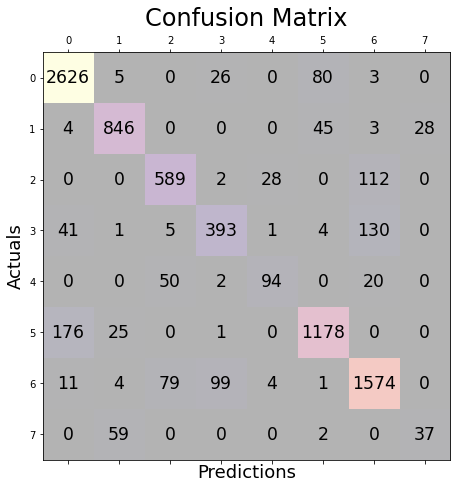

In [127]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.inferno, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

In [128]:
rows = conf_matrix.sum(axis = 1, keepdims = True)
normalized_matrix = conf_matrix / rows

np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = np.round_(normalized_matrix, 4)
normalized_matrix

array([[0.000e+00, 1.800e-03, 0.000e+00, 9.500e-03, 0.000e+00, 2.920e-02,
        1.100e-03, 0.000e+00],
       [4.300e-03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.860e-02,
        3.200e-03, 3.020e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 2.700e-03, 3.830e-02, 0.000e+00,
        1.532e-01, 0.000e+00],
       [7.130e-02, 1.700e-03, 8.700e-03, 0.000e+00, 1.700e-03, 7.000e-03,
        2.261e-01, 0.000e+00],
       [0.000e+00, 0.000e+00, 3.012e-01, 1.200e-02, 0.000e+00, 0.000e+00,
        1.205e-01, 0.000e+00],
       [1.275e-01, 1.810e-02, 0.000e+00, 7.000e-04, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [6.200e-03, 2.300e-03, 4.460e-02, 5.590e-02, 2.300e-03, 6.000e-04,
        0.000e+00, 0.000e+00],
       [0.000e+00, 6.020e-01, 0.000e+00, 0.000e+00, 0.000e+00, 2.040e-02,
        0.000e+00, 0.000e+00]])

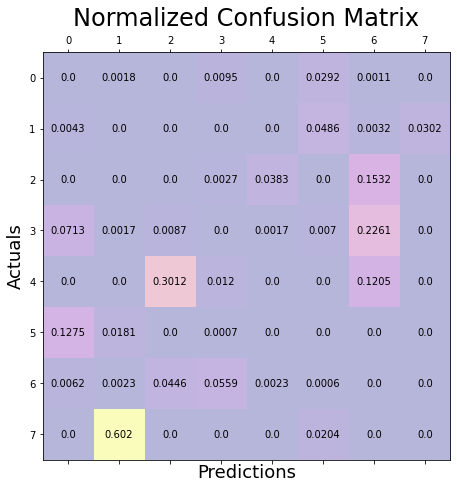

In [129]:
fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
ax2.matshow(normalized_matrix, cmap=plt.cm.plasma, alpha=0.3)

for i in range(normalized_matrix.shape[0]):
  for j in range(normalized_matrix.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix', fontsize=24)
plt.show()

In [130]:
# Recall what pitches were encoded to what number
pitch_encoded

label            encoded
4-Seam Fastball  0          32.7
Changeup         1          11.0
Curveball        2           8.7
Cutter           3           6.9
Knuckle Curve    4           2.0
Sinker           5          16.4
Slider           6          21.1
Split-Finger     7           1.2
dtype: float64

Findings:
* Some sinkers are misclassified as 4-seams
*   The most alarming error is in splitters that are predicted as changeups. The inverse is not true, meaning that the model is not good at telling splitters from changeups given an instance of a splitter, but is good at predicting instances of changeups correctly and telling them from splitters.
*   Curveballs (both kinds) and cutters are misclassified as sliders



In [131]:
print("Testing set accuracy: ", KNN.score(X_test, y_test))
print("Training set accuracy: ", KNN.score(X_train, y_train))

Testing set accuracy:  0.8747019551740581
Training set accuracy:  0.9168703427719821


In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2740
           1       0.90      0.91      0.91       926
           2       0.81      0.81      0.81       731
           3       0.75      0.68      0.72       575
           4       0.74      0.57      0.64       166
           5       0.90      0.85      0.88      1380
           6       0.85      0.89      0.87      1772
           7       0.57      0.38      0.45        98

    accuracy                           0.87      8388
   macro avg       0.81      0.76      0.78      8388
weighted avg       0.87      0.87      0.87      8388



##Naive Bayes

## Random Forest Classifier